In [1]:
!pip install pycm

In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
import pandas as pd
import unicodedata
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow_datasets as tfds
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
    
from pycm import *

In [3]:
VOCABULARY_SIZE = 2500
BATCH_SIZE      = 100
VAL_FREQ        = 50
LR              = 5e-4
EPOCHS          = 10
LOG_DIR         = './exp'

In [4]:
def vis_1d_plot(x,color):    
    data = {'x':x,'y':np.zeros_like(x),'color':color}
    sns.set_style("whitegrid")
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.50
    plt.figure(figsize=(6,5))
    plt.scatter(data['x'],data['y'],alpha=0.05,color=data['color'])
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Positive Class',markerfacecolor='b', markersize=12),
                       Line2D([0], [0], marker='o', color='w', label='Negative Class',markerfacecolor='r', markersize=12)]
    plt.legend(handles=legend_elements,fontsize=15)
    plt.ylim(-1,1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(os.path.join(log_dir,"dataset1d.pdf"),format='pdf',bbox_inches='tight')
    plt.show()
    
def vis_3d_plot(x,y,z,color):
    df  = pd.DataFrame.from_dict({'x':x,'y':y,'z':z,'color':color})
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color='color')

    fig.show()

In [5]:
def load_dataset(name='imdb_reviews',DATASET_DIR='./'):
    dataset, info = tfds.load(name, with_info=True,as_supervised=True)
    train_dataset, test_dataset = dataset['train'], dataset['test']
    
    example_strings = []
    colors          = []
    
    N = 50000
    i = 0
    for example,label in train_dataset:
      example_strings.append(str(example.numpy()))
      color = 'r' if label==0 else 'b'
      colors.append(color)
      i = i+1
      if(i>N):
        break
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCABULARY_SIZE)
    tokenizer.fit_on_texts(example_strings)
    
    document_matrix = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(example_strings), mode='tfidf')
    print("TF-IDF Matrix Shape : ",document_matrix.shape)
    
    svd = TruncatedSVD(n_components=2)
    svd.fit(document_matrix)
    projected_data = svd.transform(document_matrix)
    print("Projected Data Shape : ",projected_data.shape)
    plot_data(projected_data,DATASET_DIR,colors)
    
    svd_3d = TruncatedSVD(n_components=3)
    svd_3d.fit(document_matrix)
    projected_data_3d = svd_3d.transform(document_matrix)
    print("Projected Data Shape : ",projected_data_3d.shape)
    vis_3d_plot(projected_data_3d[:,0],projected_data_3d[:,1],projected_data_3d[:,2],colors)
    
    svd_1d = TruncatedSVD(n_components=1)
    svd_1d.fit(document_matrix)
    projected_data_1d = svd_1d.transform(document_matrix)
    print("Projected Data Shape : ",projected_data_1d.shape)
    vis_1d_plot(projected_data_1d,colors)
    
    
    return train_dataset, test_dataset, tokenizer,example_strings
    

In [6]:
def process_data(dataset):
  example_strings = []
  labels          = []
  for example,label in zip(dataset[0],dataset[1]):
    example_strings.append(str(example.numpy()))
    labels.append(label)
  
  return example_strings,labels

In [7]:
def plot_data(projected_data,log_dir="./",colors=None):
    sns.set_style("whitegrid")
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.50
    plt.figure(figsize=(6,5))
    plt.scatter(projected_data[:,0],projected_data[:,1],alpha=0.05,color=colors)
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Positive Class',markerfacecolor='b', markersize=12),
                       Line2D([0], [0], marker='o', color='w', label='Negative Class',markerfacecolor='r', markersize=12)]
    plt.legend(handles=legend_elements,fontsize=15)
    plt.xlim(0,35)
    plt.ylim(-15,15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(os.path.join(log_dir,"dataset.pdf"),format='pdf',bbox_inches='tight')
    plt.show()

In [8]:
def build_model(n_layers=3,n_hidden=128,output_dim=2,input_dim=VOCABULARY_SIZE):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(n_hidden,activation='relu',input_dim=input_dim))
  for _ in range(n_layers-1):
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(output_dim,activation='softmax'))
  return model

In [9]:

def run_exp(mode='tfidf',train_dataset=None,test_dataset=None,tokenizer=None,svd_components=-1,svd=None,n_layers=3,n_hidden=128,output_dim=2,input_dim=VOCABULARY_SIZE,LR=LR,BATCH_SIZE=BATCH_SIZE):
  
  if(svd_components>0):
    input_dim   = svd_components 

  model         = build_model(n_layers,n_hidden,output_dim,input_dim)
  opt           = tf.keras.optimizers.Adam(LR)
  loss_fxn      = tf.keras.losses.binary_crossentropy
  train_dataset = train_dataset.batch(BATCH_SIZE)
  test_dataset  = test_dataset.batch(len(test_dataset)//10)

  val_acc   = []
  train_acc = []
  test_acc  = []

  for ep in range(EPOCHS):
    print("\n","=="*10,"EPOCH :  ",ep,"=="*10,"\n")
    progbar = tf.keras.utils.Progbar(len(train_dataset),stateful_metrics=["loss","acc"])
    for iteration,data_batch in enumerate(train_dataset):
        
        if(iteration%VAL_FREQ == 0):
          for val_batch in test_dataset:
            x_val,y_val = process_data(val_batch)
            x_val = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(x_val),mode=mode)
            
            if(svd_components>0):
              x_val = svd.transform(x_val)
  
            y_val = tf.one_hot(y_val,2)
            y_val_pred = model(x_val,training=False)
            acc    = accuracy_score(np.argmax(y_val,axis=1),np.argmax(y_val_pred,axis=1))
            val_acc.append(acc)
            break
        
        x,y_true = process_data(data_batch)
        x = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(x),mode=mode)
        y_true = tf.one_hot(y_true,2)

        if(svd_components>0):
          x = svd.transform(x)

        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss   = loss_fxn(y_true,y_pred)
        
        acc    = accuracy_score(np.argmax(y_true,axis=1),np.argmax(y_pred,axis=1))
        train_acc.append(acc)

        
        gradients = tape.gradient(loss,model.trainable_variables)
        opt.apply_gradients(zip(gradients,model.trainable_variables))
        
        progbar.update(iteration,[("loss",loss),("train_acc",train_acc[-1]),("val_acc",val_acc[-1])])

  test_acc = []
  for test_batch in test_dataset:
      x_test,y_test = process_data(test_batch)
      x_test = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(x_test),mode=mode)
      
      if(svd_components>0):
          x_test = svd.transform(x_test)

      y_test = tf.one_hot(y_test,2)
      y_test_pred = model(x_test,training=False)
      acc    = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_test_pred,axis=1))
      test_acc.append(acc)

  print("\n\t----------\n\tTEST ACC : {:3f} +- {:3f}% \n\t----------\n".format(100*np.mean(test_acc),100*np.std(test_acc)))
  cm = ConfusionMatrix(actual_vector=np.argmax(y_test,axis=1), predict_vector=np.argmax(y_test_pred,axis=1))
  return train_acc,val_acc,test_acc,cm,model

In [10]:
def plot_acc(train_acc,val_acc,test_acc,log_dir):
  sns.set_style("whitegrid")
  plt.rcParams["axes.edgecolor"] = "0.15"
  plt.rcParams["axes.linewidth"]  = 1.50
  plt.figure(figsize=(6,5))
  
  plt.plot(range(len(train_acc)),train_acc,color='b', linestyle='--')
  plt.plot([VAL_FREQ*n for n in range(len(val_acc))],val_acc,color='r', linestyle='-',linewidth=2.0)
  plt.axhline(y=np.mean(test_acc), color='g', linestyle='--',linewidth=2.5,marker='o')
  legend_elements = [Line2D([0], [0], marker='o', color='b', label='Training',markerfacecolor='b', markersize=8),
                     Line2D([0], [0], marker='o', color='r', label='Validation',markerfacecolor='r', markersize=8),   
                     Line2D([0], [0], marker='o', color='g', label='Testing',markerfacecolor='g', markersize=8)] 
  plt.legend(handles=legend_elements,fontsize=12,ncol=3)
  plt.xlabel("Iteration" , fontsize=15)
  plt.ylabel("Accuracy"  , fontsize=15)
  plt.xticks(fontsize=13)
  plt.ylim(0.40,1.05)
  plt.yticks(fontsize=13)
  plt.savefig(os.path.join(log_dir,"accuracy.eps"),format='eps',bbox_inches='tight')
  plt.show()


In [11]:
def plot_eigval(eigv,palette='magma',save_dir='.'):
    sns.set_style("whitegrid")
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.50
    n = eigv.shape[0]
    x = [i for i in range(1,n+1)]
    y = [eigv[i] for i in range(n)]
    df = pd.DataFrame.from_dict( {'x':x,'y':y})
    plt.figure(figsize=(4,4))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    ax = sns.barplot(x="x", y="y", data=df,palette=palette)
    plt.ylabel(r'$\Re(\lambda)$',fontsize=15)
    plt.xlabel(r"$K$",fontsize=15)
    plt.xlim(-1,10.5)
    plt.ylim(-2,np.max(eigv)+1)
    plt.savefig("{}/eigv.eps".format(save_dir),format='eps',bbox_inches='tight')
    plt.show()

In [12]:
def main():
    svd_components_list  = [-1,2,5,10,50,100,200,400,600,800,1000,1500,2000,2400] 
    modes                = ['tfidf','freq','count']
    modes                = ['binary','count']
    dataset_names        = ['yelp_polarity_reviews','imdb_reviews']
    dataset_names        = ['yelp_polarity_reviews']
    
    for dataset_name in dataset_names:
        print("-----------------DATASET : {} -------------------".format(dataset_name))
        DATASET_DIR = os.path.join(LOG_DIR,"{}".format(dataset_name))
        os.makedirs(DATASET_DIR,exist_ok=True)
        
        train_dataset,test_dataset,tokenizer,example_strings = load_dataset(dataset_name,DATASET_DIR)
        

        for svd_components in svd_components_list:
            for mode in modes:
                log_dir  = os.path.join(DATASET_DIR,"mode_{}".format(mode),"svd_{}".format(svd_components))
                ckpt_dir = os.path.join(log_dir,'checkpoints')
                os.makedirs(ckpt_dir,exist_ok=True)
                print("==="*20+"\n RUNNING EXP : MODE:{} SVD:{}\n".format(mode,svd_components),"==="*20+"\n")
                svd                  = None
                if(svd_components>0):
                    document_matrix = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(example_strings), mode=mode)
                    print("Document Matrix Shape : ",document_matrix.shape)
                    svd = TruncatedSVD(n_components=svd_components)
                    svd.fit(document_matrix)
                train_acc,val_acc,test_acc,cm,model = run_exp(train_dataset=train_dataset,test_dataset=test_dataset,mode=mode,tokenizer=tokenizer,svd_components=svd_components,svd=svd)
                model.save_weights(os.path.join(ckpt_dir,"model.ckpt"))
                save_data = {
                    "train_acc":train_acc,
                    "val_acc":val_acc,
                    "test_acc":test_acc,
                    "cm":cm
                }
                with open(os.path.join(log_dir,"exp_data"),'wb') as f:
                    pickle.dump(save_data,f)
                plot_acc(train_acc,val_acc,test_acc,log_dir)

In [13]:
main()

-----------------DATASET : yelp_polarity_reviews -------------------
---------------------------------------- 
 MODE : binary
 ----------------------------------------
Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_644 (Dense)            (None, 128)               76928     
_________________________________________________________________
batch_normalization_644 (Bat (None, 128)               512       
_________________________________________________________________
batch_normalization_645 (Bat (None, 128)               512       
_________________________________________________________________
dense_645 (Dense)            (None, 2)                 258       
Total params: 78,210
Trainable params: 77,698
Non-trainable params: 512
_________________________________________________________________
Document Matrix Shape :  (50001, 2500)


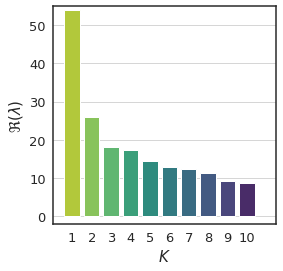

Eigen Values of Hessian :  [53.894688 26.04438  18.020695 17.417404 14.372216 12.82609  12.350969
 11.17316   9.104405  8.740886]
 SVD : 600   #Parameters :  78210  Ratio : 24.333405930120406
---------------------------------------- 
 MODE : count
 ----------------------------------------
Model: "sequential_323"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_646 (Dense)            (None, 128)               76928     
_________________________________________________________________
batch_normalization_646 (Bat (None, 128)               512       
_________________________________________________________________
batch_normalization_647 (Bat (None, 128)               512       
_________________________________________________________________
dense_647 (Dense)            (None, 2)                 258       
Total params: 78,210
Trainable params: 77,698
Non-trainable params: 512
____________________

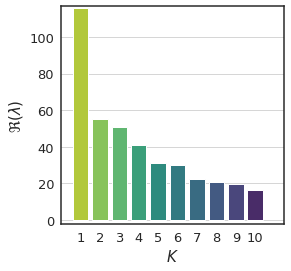

Eigen Values of Hessian :  [115.64687   55.01657   51.069355  41.02234   31.21596   30.17022
  22.363775  21.069695  19.935368  16.460323]
 SVD : 600   #Parameters :  78210  Ratio : 24.333405930120406


In [85]:
svd_components_list  = [-1,2,5,10,50,100,200,400,600,800,1000,1500,2000]
modes                = ['binary','count']
dataset_names        = ['yelp_polarity_reviews','imdb_reviews']

svd_components_list  = [600]
modes                = ['binary','count']
dataset_names        = ['yelp_polarity_reviews']


data = {}
for dataset_name in dataset_names:
    print("-----------------DATASET : {} -------------------".format(dataset_name))
    DATASET_DIR = os.path.join(LOG_DIR,"{}".format(dataset_name))
    
    train_dataset,test_dataset,tokenizer,example_strings = load_dataset(dataset_name,DATASET_DIR)
    data[dataset_name]={}
    for mode in modes:
        data[dataset_name][mode]={}
        print('--'*20,"\n MODE : {}\n".format(mode),"--"*20)
        for svd_components in svd_components_list:
            log_dir  = os.path.join(DATASET_DIR,"mode_{}".format(mode),"svd_{}".format(svd_components))
            ckpt_dir = os.path.join(log_dir,'checkpoints')
            
            input_dim=2500
            if(svd_components>0):
                input_dim   = svd_components 

            model         = build_model(input_dim=input_dim)
            model.load_weights(os.path.join(ckpt_dir,"model.ckpt"))
            model.summary()
            train_dataset_b = train_dataset.batch(BATCH_SIZE)
            for iteration,data_batch in enumerate(train_dataset_b):
                x,y_true = process_data(data_batch)
                x = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(x),mode=mode)
                y_true = tf.one_hot(y_true,2)

                if(svd_components>0):
                    document_matrix = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(example_strings), mode=mode)
                    print("Document Matrix Shape : ",document_matrix.shape)
                    svd = TruncatedSVD(n_components=svd_components)
                    svd.fit(document_matrix)
                    x = svd.transform(x)


                layer = model.layers[-1]
                with tf.GradientTape() as t2:
                  with tf.GradientTape() as t1:
                    y_pred = model(x)
                    loss   = tf.keras.losses.binary_crossentropy(y_true,y_pred)

                  g = t1.gradient(loss, layer.kernel)
                h = tf.reshape(t2.jacobian(g, layer.kernel),[256,256])
                
                eigv = np.real(tf.linalg.eigvals(h).numpy())
                eigv = eigv[np.argsort(eigv)[-10:]]
                eigv = eigv[::-1]
                palette = 'magma_r' if 'imdb' in dataset_name else 'viridis_r'
                plot_eigval(eigv,palette=palette,save_dir=log_dir)
                print("Eigen Values of Hessian : ", eigv) 
                break
            with open(os.path.join(log_dir,"exp_data"),'rb') as f:
                save_data = pickle.load(f)
#                 print(" SVD : {} - TEST-ACC : {}".format(svd_components,np.mean(save_data['test_acc']))," #Parameters : ",model.count_params())
                print(" SVD : {} ".format(svd_components)," #Parameters : ",model.count_params()," Ratio : {}".format(100*model.count_params()/321410)) 
                data[dataset_name][mode]["{}".format(svd_components)] = save_data
#                 print(save_data['test_acc'])

-----------------DATASET : yelp_polarity_reviews -------------------


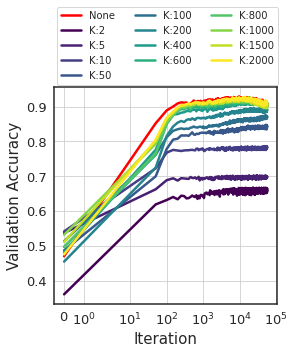

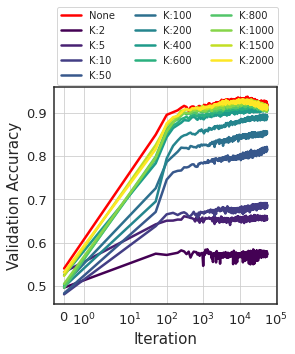

-----------------DATASET : imdb_reviews -------------------


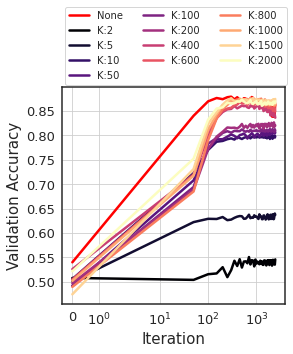

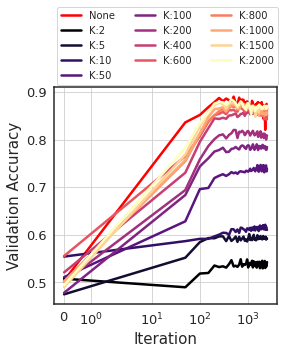

In [84]:
svd_components_list  = [-1,2,5,10,50,100,200,400,600,800,1000,1500,2000]
modes                = ['binary','count']
dataset_names        = ['yelp_polarity_reviews','imdb_reviews']

for dataset_name in dataset_names:
    print("-----------------DATASET : {} -------------------".format(dataset_name))
    for mode in modes:
        sns.set_style("whitegrid")
        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"]  = 1.50
        plt.figure(figsize=(4,4))
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        
        val_acc = data[dataset_name][mode]["{}".format(-1)]['val_acc']
        plt.plot([50*n for n in range(len(val_acc))],val_acc,color='r',linewidth=2.5,label="None")
        
        if("imdb" in dataset_name):
            colors = plt.cm.magma(np.linspace(0,1,len(svd_components_list)-1))
        else:
            colors = plt.cm.viridis(np.linspace(0,1,len(svd_components_list)-1))
        for i,svd_components in enumerate(svd_components_list[1:]):
            val_acc = data[dataset_name][mode]["{}".format(svd_components)]['val_acc']
            plt.plot([50*n for n in range(len(val_acc))],val_acc,color=colors[i],linewidth=2.5,label="K:{}".format(svd_components))
        
        plt.ylabel("Validation Accuracy",fontsize=15)
        plt.xlabel("Iteration",fontsize=15)
        plt.xscale('symlog')
        plt.legend(loc=2,bbox_to_anchor=(-0.01,1.390),ncol=3)
        plt.savefig('plots/{}_{}.eps'.format(dataset_name,mode),format='eps',bbox_inches='tight')
        plt.show()